# Naive representation

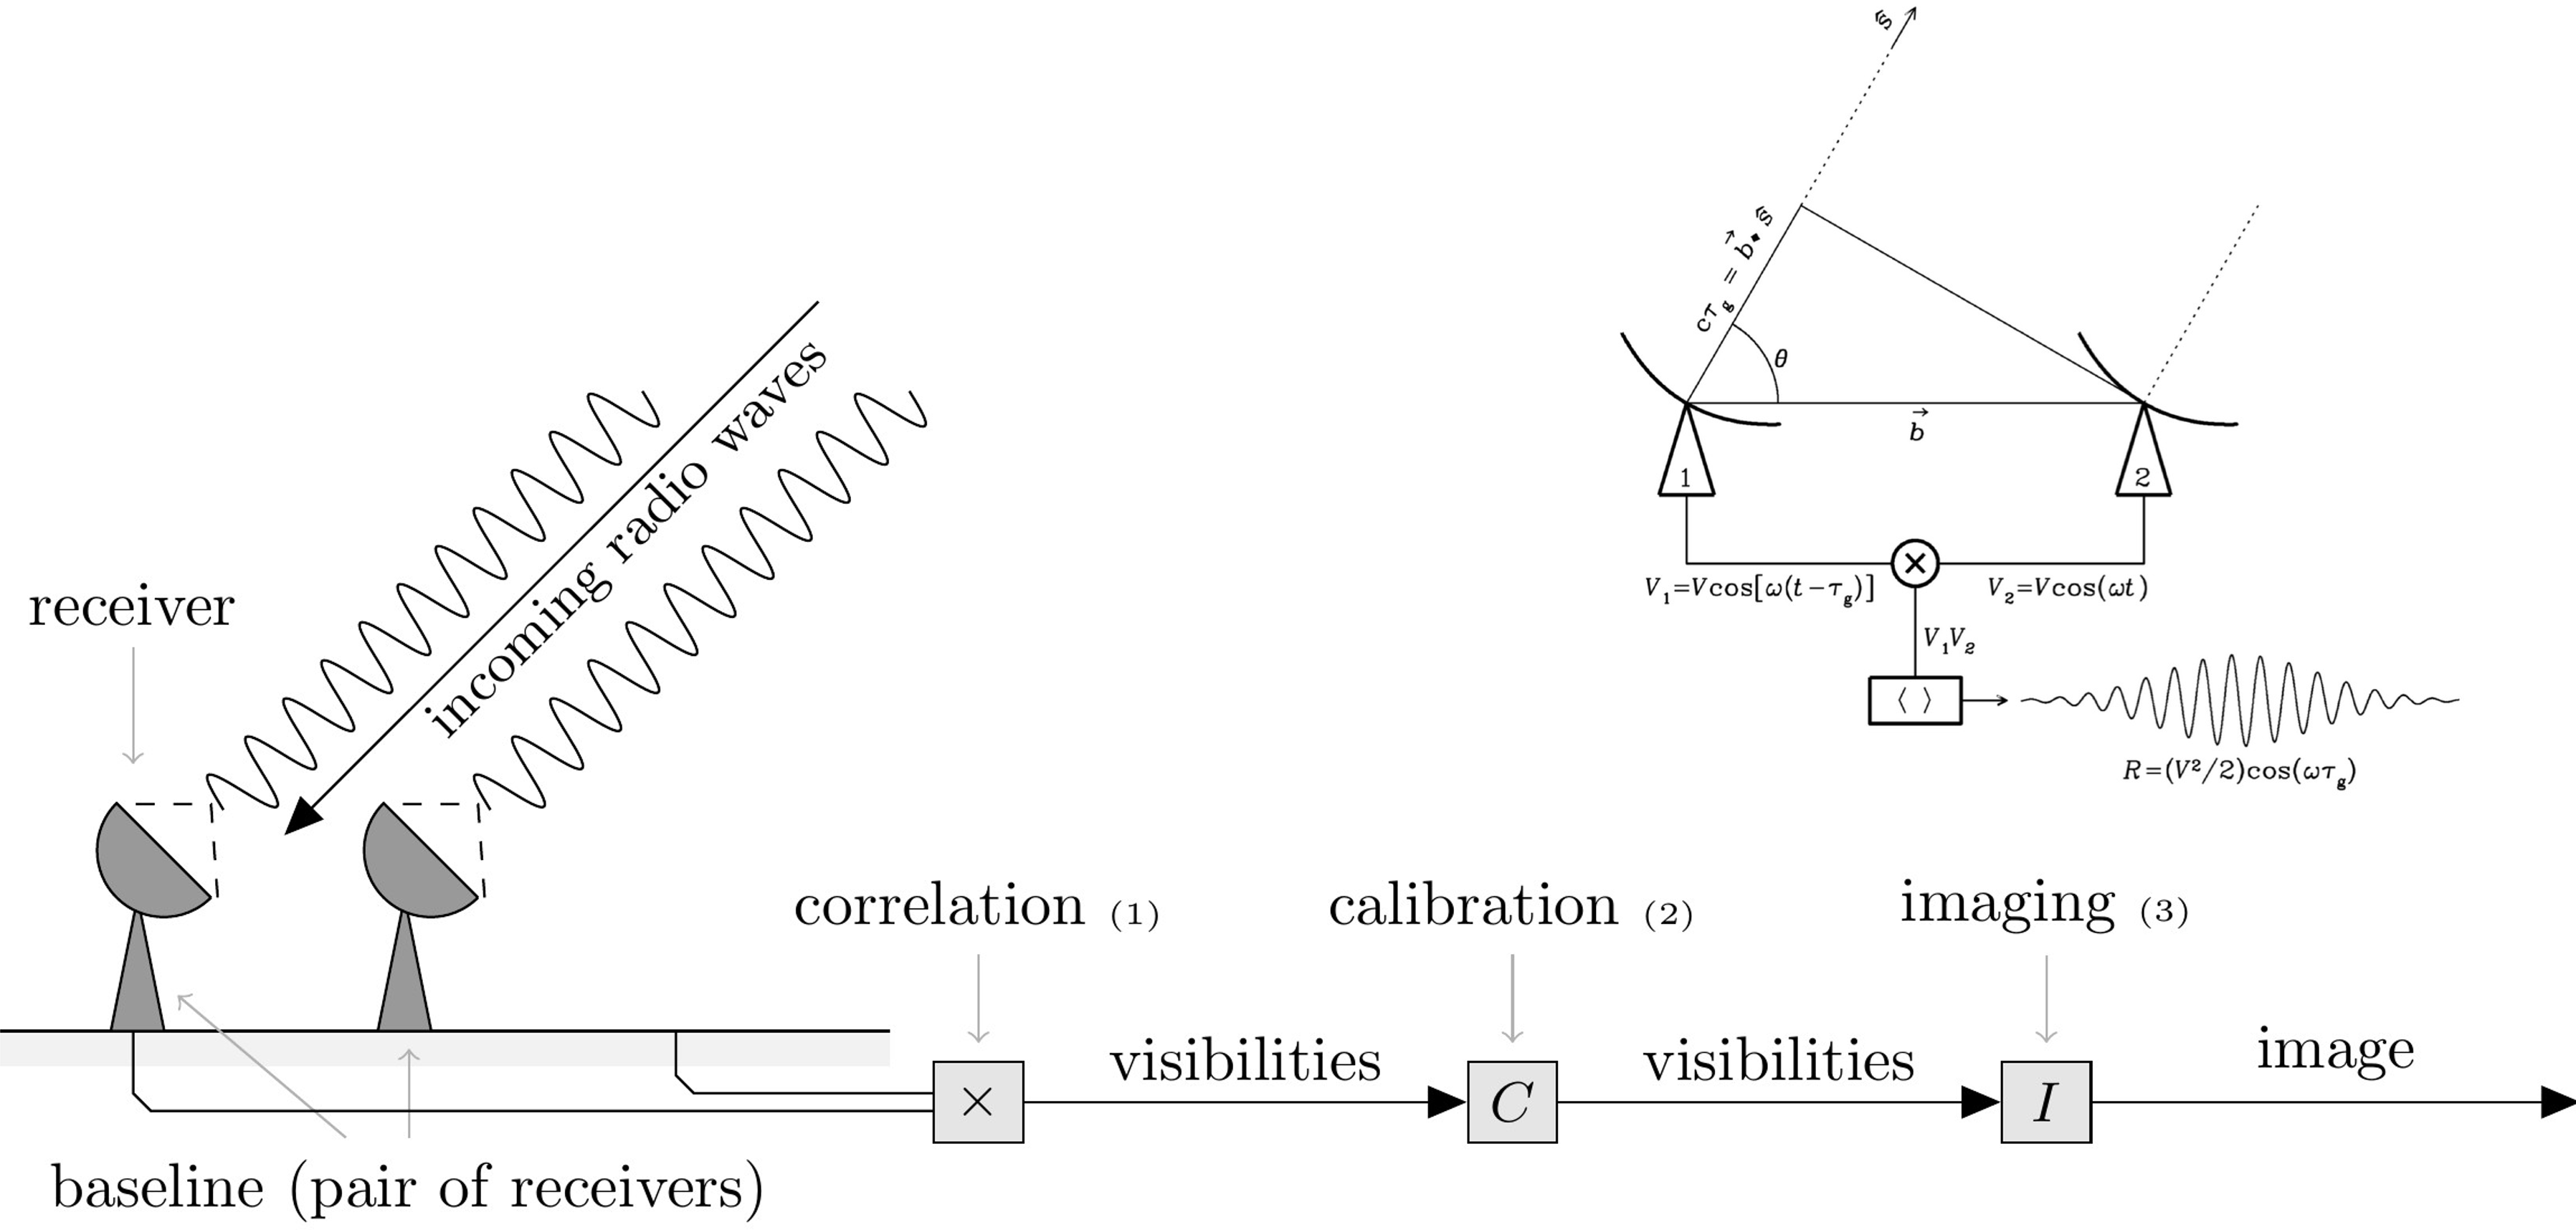

*The pipeline:*
* **1. Data preparation (correlation step):**
    * 1.1 image initialization (spatial domain)
    * 1.2 Fourier transform (frequency domain)
    
    &rarr; simulates radio visibility data
* **2. Data embedding (calibration step):**
    * 2.1 data pre-processing
    * 2.2 data encoding
    
    &rarr; embeds visibilities into qubits
* **3. Data reading (imaging step):**
    * 3.1 readout
    * 3.2 inverse Fourier transform (spatial domain) - IFT
    
    &rarr; approximates science-ready intermediate product  

*Note: we consider a single polarisation axis for a single frequency channel in a given time sample*

*Digital encoding (binary):*

* circuit family #1 from [Cortese 2018](https://arxiv.org/abs/1803.01958)
* to many features to simulate for PennyLane's implementation - Basis embedding ([Teamplates](https://docs.pennylane.ai/en/stable/introduction/templates.html))

#### Prerequisites

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct

import qiskit
from qiskit import *

In [2]:
# float to binary 
def float_to_bin_real(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')
def float_to_bin_imag(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')

# binary to float
def bin_to_float_real(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]
def bin_to_float_imag(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]

# reverse a string (for the measurement step readout)
def reverse(string):
    string = string[::-1]
    return string

## 1. Data preparation (correlation step)

### 1.1 image initialization (spatial domain)

In [3]:
# image of the sky filled with double precision complex floats (single precision for reals/imaginaries)
# few pixels are set to relatively large complex random values in random spots (image sources)
# relatively small complex values are added (white noise from background radiations) 

n = 10 #number of antennas

sky_image = np.zeros((n, n), dtype='complex64')
mask = np.zeros((n, n), dtype='bool')
stars = np.random.randint(1, 7) #random number of sources
radius = 1 

for i in range(0, stars):
    index_i = np.random.randint(0, n-radius)
    index_j = np.random.randint(0, n-radius)
    for j in range(0, radius):
        for k in range(0, radius):
            sky_image[index_i+j][index_j+k] = complex(np.random.rand()*100, np.random.rand()*100)
            mask[index_i+j][index_j+k] = True
            
sky_image.real += np.random.randn(n,n)/100
sky_image.imag += np.random.randn(n,n)/100

print(sky_image)

[[ 1.60082257e+00+6.46470108e+01j  7.87408557e-03-8.44549574e-03j
   3.66772874e-03+4.25895397e-03j -1.22971332e-03+4.73602396e-03j
   3.59909306e-03+4.33182227e-04j -9.23979934e-03+8.79724044e-03j
  -2.46603340e-02-2.57796375e-03j  3.28730140e-03+2.18884600e-03j
  -1.32598225e-02-6.07753126e-03j  2.40595639e-02-8.03024322e-03j]
 [ 3.78560321e-03-2.92174867e-03j  3.99212091e-04-1.62979085e-02j
  -1.10085066e-02-5.09094039e-04j -8.22643749e-03+8.76664463e-03j
   8.94798839e-04+4.33626445e-03j -1.31746067e-03-7.58675206e-03j
   2.52654892e-03-7.98455067e-03j -1.36960587e-02+2.93899537e-03j
  -1.83216366e-03+1.10645480e-02j -2.58439803e-03+5.47880027e-03j]
 [-7.60315498e-03-9.10306815e-03j  1.61776636e-02+2.52404120e-02j
   4.59011365e-03-3.37269827e-04j  9.21666063e-03+4.06755680e-05j
  -5.78319537e-04-3.79154878e-03j  4.48534219e-03+3.73096159e-03j
   1.70242935e-02+9.69930645e-03j -7.40635733e-04+1.53882941e-02j
   1.19917775e-02-3.25857988e-03j  7.54050305e-03-2.41015945e-02j]
 [-3.40

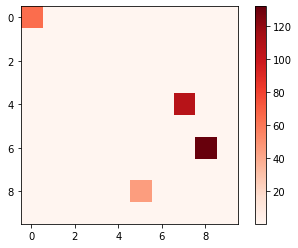

In [4]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Reds') 
cbar = plt.colorbar()

### 1.2 Fourier transform (frequency domain)

In [5]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[ 181.13628  +284.3266j    -186.52522  +178.95032j
  -110.96921   -30.358053j    68.425354  -78.54957j
    86.565674 +140.53539j     -0.8643404 +40.16405j
    58.88313  +179.04771j   -143.77992  +105.8464j
   -93.81584   -54.416435j   156.83449  -119.11634j  ]
 [-163.9892    -35.73957j    121.40577   -73.165245j
    33.73429  +134.92747j     52.26156   +45.469368j
     5.8163314+173.53743j    -90.94719  +111.1755j
  -146.68707   -59.774014j   209.82797  -113.60423j
   128.13737  +279.07214j   -133.6263   +184.49866j  ]
 [  22.412865  +82.75585j     63.457867  +97.57008j
    -5.5123854+121.49524j    -79.46468  +163.21523j
  -158.22893  -111.63359j    221.07967   -61.623333j
   116.932625 +227.0762j    -122.32488  +236.55357j
  -175.27213   -87.88184j    132.70724   -21.11201j  ]
 [  40.663036  +94.82458j   -125.4145   +189.84938j
  -112.14008  -138.45296j    174.99234   -34.706787j
   163.04085  +200.26843j   -168.46875  +263.2271j
  -129.08946  -114.51055j     86.87526    +5.7451515j


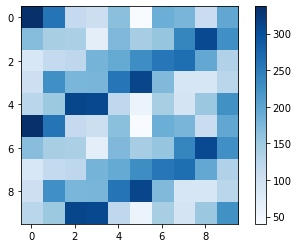

In [6]:
modulus = np.absolute(visibilities)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

#### * Sanity check

In [7]:
sanity = np.fft.ifft2(visibilities).astype('complex64')

test1_real = ((sky_image.real - sanity.real)**2).mean()
test1_imag = ((sky_image.imag - sanity.imag)**2).mean()
 
print('Reals MSE: '+ str(test1_real))
print('Imaginaries MSE: '+ str(test1_imag))

Reals MSE: 1.1686477e-13
Imaginaries MSE: 1.13626156e-13


## 2. Data embedding (calibration step)

### 2.1 data pre-processing
### 2.2 data encoding

In [8]:
# encoding binary data onto qubits
def binary_encode(qc, binary, off_set):
    
    for i in range(0, len(binary)):
        qc.reset(off_set+i) # set quantum state |0> by default for all qubits

        if binary[i]=='1':
            qc.x(off_set+i) # act as a CX (controlled X gate)
    
    off_set += len(binary)

    return off_set

In [9]:
number_of_pixels = n*n
number_of_bits_real = 32
number_of_bits_imag = 32
number_of_bits = number_of_bits_real + number_of_bits_imag
number_of_qbits = number_of_pixels*number_of_bits
off_set = 0

# encoding (n bits encoded onto n qubits)
qc = QuantumCircuit(number_of_qbits)
for i in range(0, n):
    for j in range(0, n):
            binary_real = float_to_bin_real(visibilities[i, j].real)
            binary_imag = float_to_bin_imag(visibilities[i, j].imag)
            binary = binary_real+binary_imag
            off_set = binary_encode(qc, binary, off_set)

## 3. Data reading

### 3.1 readout

In [10]:
# measurement
qc.measure_all()
backend = Aer.get_backend('aer_simulator') # Qiskit's staple simulator (CHOICE MOTIVATION?)
job = backend.run(qc, shots=1, memory=True) 
output = job.result().get_memory()[0]
out = reverse(output)

# readout
chunks_real = []
chunks_imag = []
for i in range(0, number_of_pixels):
    chunks_real.append(out[number_of_bits*i:(number_of_bits*i)+number_of_bits_real]) # real parts represented every 64 bits starting from the first one
    chunks_imag.append(out[(number_of_bits*i)+number_of_bits_imag:(number_of_bits*i)+number_of_bits_imag+number_of_bits_imag]) # imaginary parts represented every 64 bits starting after the first occurence of a real part 

readout = []
for i in range(0, len(chunks_real)):
    readout.append(complex(bin_to_float_real(chunks_real[i]), bin_to_float_imag(chunks_imag[i]))) 

readout = np.array(readout).reshape(n , n).astype('complex64')
print(readout)

[[ 181.13628  +284.3266j    -186.52522  +178.95032j
  -110.96921   -30.358053j    68.425354  -78.54957j
    86.565674 +140.53539j     -0.8643404 +40.16405j
    58.88313  +179.04771j   -143.77992  +105.8464j
   -93.81584   -54.416435j   156.83449  -119.11634j  ]
 [-163.9892    -35.73957j    121.40577   -73.165245j
    33.73429  +134.92747j     52.26156   +45.469368j
     5.8163314+173.53743j    -90.94719  +111.1755j
  -146.68707   -59.774014j   209.82797  -113.60423j
   128.13737  +279.07214j   -133.6263   +184.49866j  ]
 [  22.412865  +82.75585j     63.457867  +97.57008j
    -5.5123854+121.49524j    -79.46468  +163.21523j
  -158.22893  -111.63359j    221.07967   -61.623333j
   116.932625 +227.0762j    -122.32488  +236.55357j
  -175.27213   -87.88184j    132.70724   -21.11201j  ]
 [  40.663036  +94.82458j   -125.4145   +189.84938j
  -112.14008  -138.45296j    174.99234   -34.706787j
   163.04085  +200.26843j   -168.46875  +263.2271j
  -129.08946  -114.51055j     86.87526    +5.7451515j


### 3.2 inverse Fourier transform (spatial domain)

In [11]:
fidelity = np.fft.ifft2(readout).astype('complex64')

#### fidelity test

In [12]:
test2_real = ((sky_image.real - fidelity.real)**2).mean()
test2_imag = ((sky_image.imag - fidelity.imag)**2).mean()

print('Reals MSE: '+ str(test2_real))
print('Imaginaries MSE: '+ str(test2_imag))

Reals MSE: 1.1686477e-13
Imaginaries MSE: 1.13626156e-13


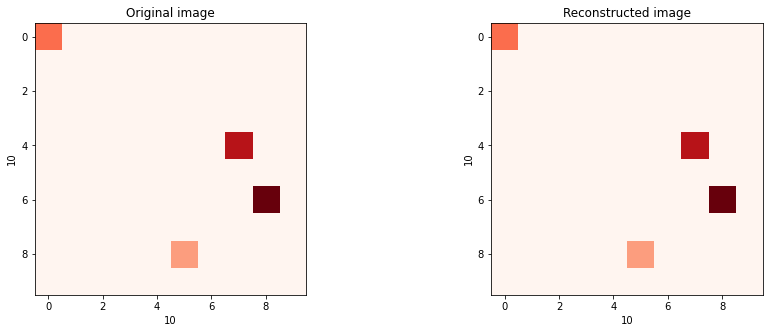

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
modulus1 = np.absolute(sky_image)
modulus2 = np.absolute(fidelity)

axs[0].imshow(modulus1, cmap='Reds')
axs[1].imshow(modulus2, cmap='Reds')

axs[0].set_title("Original image")
axs[1].set_title("Reconstructed image")

for ax in axs.flat:
    ax.set(xlabel=n, ylabel=n)

## MSEs comparison

In [14]:
print('Reals MSE from Fourier transforms: '+ '\033[1m' + str(test1_real) + '\033[0m')
print('Imaginaries MSE from Fourier transforms: '+ '\033[1m' + str(test1_imag) + '\033[0m')

print()

print('Reals MSE with quantum embedding: '+ '\033[1m' + str(test2_real) + '\033[0m')
print('Imaginaries MSE with quantum embedding: '+ '\033[1m' + str(test2_imag) + '\033[0m')

print()

print('Reals MSEs difference: '+ '\033[1m' + str(np.abs(test1_real - test2_real)) + '\033[0m')
print('Imaginaries MSEs difference: '+ '\033[1m' + str(np.abs(test1_imag - test2_imag)) + '\033[0m')

Reals MSE from Fourier transforms: 1.1686477e-13
Imaginaries MSE from Fourier transforms: 1.13626156e-13

Reals MSE with quantum embedding: 1.1686477e-13
Imaginaries MSE with quantum embedding: 1.13626156e-13

Reals MSEs difference: 0.0
Imaginaries MSEs difference: 0.0
